# Föreläsning 5

Idag kommer vi titta på urval och konfidensintervall.

#### Disposition
* Urval
    * Vikten av slumpmässiga urval
    * Svarsbortfall
    * Urvalsbias
* Intervallskattning
    * Konfidensintervall
    * Signifikansnivå
    * t-fördelning
* Räkneexempel

# Urval
När vi vill göra undersökningar eller mätningar av något så är det oftast in görbart att undersöka en hel population. Därför måste vi göra ett urval av populationen. Hur vi gör detta är viktigt för att få en bra skattning av populationen.

## Vikten av slumpmässiga urval (urvalsbias)
Det är viktigt att vi gör slumpmässiga urval. Om vi inte gör det så kan vi få ett urval som inte är representativt för populationen. Detta kan leda till att vi får felaktiga slutsatser om populationen.

Ett snedfördelat urval kan uppstå på många olika sätt:
* Urvalet kan vara icke-representativt för populationen på grund av att vi har valt ut individer på ett icke-representativt sätt. Till exempel kan vi ha valt ut individer som är lättillgängliga, eller individer som är lätt att få kontakt med.
* Svarsbortfall kan uppstå om individer väljer att inte svara på frågorna. Detta kan bero på att individen inte vill svara på frågorna, eller att individen inte förstår frågorna.
* Mätfel i form av att individen svarar felaktigt på frågorna. Eller att utrustningen som används för att mäta något inte fungerar korrekt/används felaktigt.
* Mätningarna inte är oberoende av varandra. Till exempel kan vi mäta samma individ flera gånger, eller så kan vi mäta individer som är nära varandra i populationen. T.ex. en grupp individer som bor i samma område eller som kommer tillsammans till en undersökning. 
* Bearbetningsfel. Detta kan t.ex. uppstå om vi räknar fel på något sätt, eller om vi använder felaktiga statistiska metoder för att analysera data.


### Exempel

Vi vill undersöka längden på invånarna i Karlskrona. Vi gör en undersökning med 10000 personer. Till intervjuerna kommer 8000 kvinnor och 2000 män. 

Om vi gör antagandet att fördelningen av män och kvinnor i Karlskrona är ungefär 50/50 så har vi nu råkat få ett snedfördelat underlag. Detta brukar bero på att vår process för att sampla in data inte har lyckats attrahera alla grupper som vi är intresserade av på ett representativt sätt. Det vi är ute efter är att få ett urval som är så slumpmässigt som möjligt, vilket i sin tur leder till att vi får ett urval som är så representativt som möjligt.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

nbr_males = 2000
nbr_females = 8000

female_heights = np.random.normal(loc = 165.5, scale = 6, size = nbr_females)
male_heights = np.random.normal(loc = 178.9, scale = 7, size = nbr_males)

all_heights = np.append(female_heights, male_heights)
all_genders = ['F'] * nbr_females + ['M'] * nbr_males

df = pd.DataFrame({'Gender': all_genders, 'Height': all_heights})
df.head()

,Gender,Height
0,F,164.978061
1,F,159.376448
2,F,166.163489
3,F,157.116266
4,F,162.928714


Om vi plottar vårt urval så ser det ut så här:

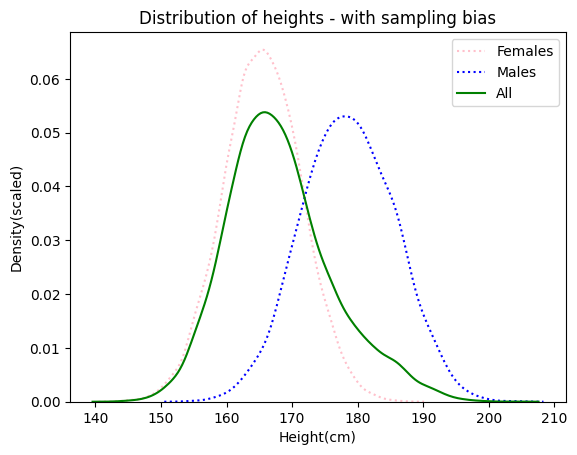

In [12]:
plt.figure()
sns.distplot(pd.Series(female_heights, name = "Height(cm)"), hist = False, label = "Females",
             color='pink', kde_kws={'linestyle': 'dotted'})
sns.distplot(pd.Series(male_heights, name = "Height(cm)"), hist = False, label = "Males", 
             color = 'blue', kde_kws={'linestyle': 'dotted'})
sns.distplot(all_heights, hist = False, label = "All", 
             color = 'green')

plt.gca().set_ylabel('Density(scaled)')
plt.gca().set_title('Distribution of heights - with sampling bias')
plt.legend()
plt.show()

Om vi skulle dra slutsatser från denna skulle vi antagligen underskatta längden på män i Karlskrona. 

#### Hur kan vi få ett slumpmässigt urval?

Ett sätt är att vikta våra datapunkter och sedan göra ett nytt urval.

In [3]:
def set_weight(row):
    if row['Gender'] == 'F':
        row['Weight'] = 0.25
    else:
        row['Weight'] = 1
    return row

df_with_weights = df.apply(set_weight, axis = 1)
df_with_weights.head()

,Gender,Height,Weight
0,F,163.753815,0.25
1,F,163.492854,0.25
2,F,146.749269,0.25
3,F,170.850154,0.25
4,F,162.538192,0.25


Vi gör ett nytt urval med `DataFrame.sample(..., weights=...)` där vi ger vikterna från kolumnen `Weight` för att vikta urvalet till att bli närmare $50/50$.

In [13]:
sample = df_with_weights.sample(n=1000, weights='Weight')
print('Number of males: ', sample[sample.Gender == 'M'].shape[0])
print('Number of females: ', sample[sample.Gender == 'F'].shape[0])

Number of males:  497
Number of females:  503


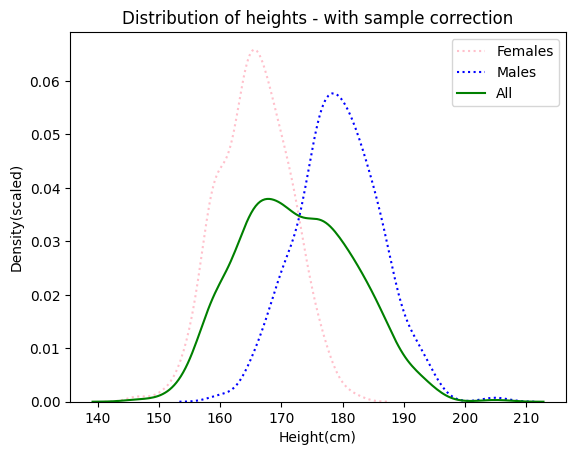

In [14]:
plt.figure()
sns.distplot(pd.Series(sample[sample.Gender == 'F'].Height, name = "Height(cm)"), hist = False, label = "Females",
             color='pink', kde_kws={'linestyle': 'dotted'})
sns.distplot(pd.Series(sample[sample.Gender == 'M'].Height, name = "Height(cm)"), hist = False, label = "Males", 
             color = 'blue', kde_kws={'linestyle': 'dotted'})
sns.distplot(sample.Height, hist = False, label = "All", 
             color = 'green')

plt.gca().set_xlabel('Height(cm)')
plt.gca().set_ylabel('Density(scaled)')
plt.gca().set_title('Distribution of heights - with sample correction')
plt.legend()
plt.show()

# Konfidensintervall

Tidigare har vi sett att vi kan göra skattningar av väntevärde och varians med hjälp av t.ex. medelvärdet och stickprovsvariansen. Dessa skattningar är dock inte helt tillförlitliga då de bara i medel träffar den korrekta punkten.

Ett sätt att utvärdera hur säkra vi är på att våra skattningar är korrekta är att beräkna ett konfidensintervall. Detta är ett intervall där vi är säkra på att den sanna värdet ligger inom intervallet med en viss sannolikhet. Vi kan t.ex. säga att vi är $95\%$ säkra på att väntevärdet ligger inom intervallet.

### Konfidensgrad/Signifikansnivå

För att beskriva hur säkra vi är på att en punktskattning befinner sig inom ett konfidensintervall använder vi oss av konfidensgrad eller signifikansnivå. Signifikansnivån brukar betecknas med $\alpha$ och är en sannolikhet. Vi kan t.ex. säga att vi är $95\%$ säkra på att väntevärdet ligger inom intervallet. Detta motsvarar då en signifikansnivå på $\alpha = 0.05$ och i detsamma en konfidensgrad av $95\%$.

Konfidensgraden/"Bredden" på konfidensintervallet är alltså $1-\alpha$.

#### Exempel

In [15]:
# Generera en normalfördelad variabel 
# Beräkna sedan konfidensintervallet för medelvärdet med olika konfidensgrader

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Konfidensgrader
conf = [0.95, 0.99, 0.999]

# Normalfördelad variabel med medelvärde 0 och standardavvikelse 0.1
mean = 0
std = .1
X = stats.norm(mean, std)

# Beräkna konfidensintervallet för medelvärdet
n = 100        # Antal observationer

x = X.rvs(n)    # Generera n observationer


Konfidensintervallet för medelvärde beräknas med:

$$\bar{X} \pm z_{\alpha/2} \cdot \frac{s}{\sqrt{n}}$$

där $z_{\alpha/2}$ är kritiskt värde för en normalfördelning med konfidensgrad $1-\alpha$. Då vi känner till att våra data följer en normalfördelning kan vi använda kvantilvärdena från normalfördelningen, vilka vi kan hitta i tabeller eller med hjälp av Python.

| $\alpha$ | $z_{\alpha}$  $(\lambda_{\alpha})$|
|----------|----------------|
| $0.10$   | $1.28$         |
| $0.05$   | $1.64$         |
| $0.025$  | $1.96$         |
| $0.01$   | $2.32$         |
| $0.005$  | $2.58$         |




Konfidensgrad:  0.95
Konfidensintervallet: [ -0.007378975520657884 ,  0.0290698858150308 ]

Konfidensgrad:  0.99
Konfidensintervallet: [ -0.01310550666895368 ,  0.034796416963326596 ]

Konfidensgrad:  0.999
Konfidensintervallet: [ -0.01975101333477688 ,  0.04144192362914979 ]



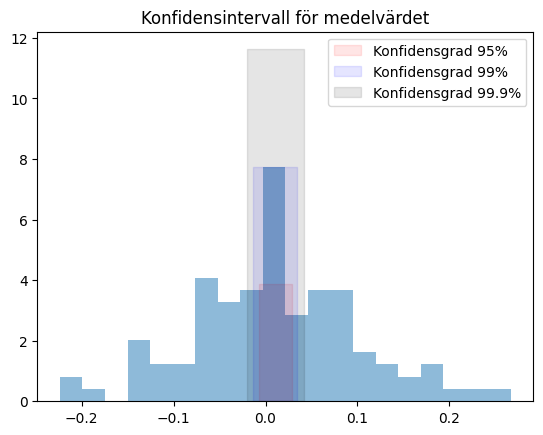

In [16]:
# Beräkna konfidensintervallet för medelvärdet
xbar = np.mean(x)   # Beräkna medelvärdet
s = np.std(x, ddof=1)   # Beräkna standardavvikelsen

# Gränsvärden för konfidensintervallet vid olika konfidensgrader
lower = []
upper = []
for c in conf:
    lower.append(xbar - stats.norm.ppf((1+c)/2)*s/np.sqrt(n))
    upper.append(xbar + stats.norm.ppf((1+c)/2)*s/np.sqrt(n))
    print('Konfidensgrad: ', c)
    print('Konfidensintervallet: [', lower[-1], ', ', upper[-1], ']\n')

# Plotta histogrammet för de genererade observationerna tillsammans med konfidensintervallen för medelvärdet
height, bins, patches = plt.hist(x, bins=20, density=True, alpha=0.5)

plt.fill_betweenx([0, height.max()/2], lower[0], upper[0], color='r', alpha=0.1)
# plt.fill_betweenx([0, 1], lower[0], upper[0], color='r', alpha=0.1)
plt.fill_betweenx([0, height.max()], lower[1], upper[1], color='b', alpha=0.1)
plt.fill_betweenx([0, height.max()*1.5], lower[2], upper[2], color='k', alpha=0.1)
plt.legend(['Konfidensgrad 95%', 'Konfidensgrad 99%', 'Konfidensgrad 99.9%'])
plt.title('Konfidensintervall för medelvärdet')
plt.show()


## Ensidigt och tvåsidigt konfidensintervall

Konfidensintervallet kan vara ensidigt eller tvåsidigt. 
* Ett ensidigt konfidensintervall är ett intervall där vi är säkra på att värdet ligger inom intervallet i en viss riktning. T.ex. kan vi säga att vi är $95\%$ säkra på att väntevärdet är större än $5$. 
* Ett tvåsidigt konfidensintervall är ett intervall där vi är säkra på att värdet ligger inom intervallet i båda riktningarna. T.ex. kan vi säga att vi är $95\%$ säkra på att väntevärdet ligger mellan $4$ och $6$.

Alltså ligger en stor skillnad i hur vi fördelar konfidensgraden mellan de olika sidorna av intervallet. 
* Ensidigt konfidensintervall: $1-\alpha$ av konfidensgraden fördelas till den ena sidan av intervallet.
* Tvåsidigt konfidensintervall: $1-\alpha$ av konfidensgraden fördelas lika mellan de två sidorna av intervallet.

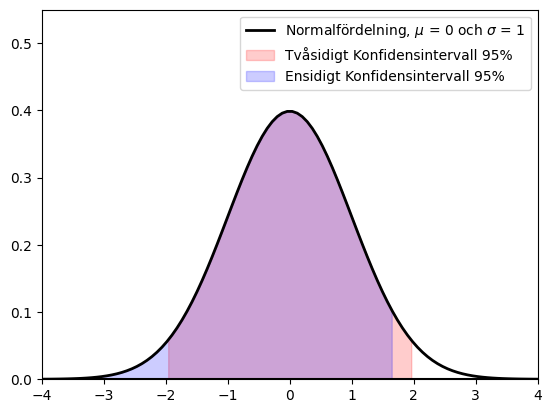

Tvåsidigt konfidensintervall 95%: [-1.959963984540054, 1.959963984540054]
Ensidigt konfidensintervall 95%: [-inf, 1.6448536269514722]


In [17]:
# Jämför ensidigt med tvåsidigt konfidensintervall i en normalfördelning

# Plottar normalförldelningen
mu = 0
sigma = 1
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, 'k', lw=2)

# Fyll mellan tvåsidga konfidensintervallet vid 95%, x=-1.96 och x=1.96
limit_two_sided = stats.norm.ppf(0.975)
ix = np.linspace(mu - limit_two_sided*sigma, mu + limit_two_sided*sigma)
iy = stats.norm.pdf(ix, 0, 1)
plt.fill_between(ix, iy, color='r', alpha=0.2)

# Fyll mellan ensidga övre begränsade konfidensintervallet vid  95%, x=-inf and x=1.64
limit_one_sided = stats.norm.ppf(0.95)
ix = np.linspace(-4, mu + limit_one_sided*sigma)
iy = stats.norm.pdf(ix, 0, 1)
plt.fill_between(ix, iy, color='b', alpha=0.2)

# Sätt x gränser
plt.xlim(-4, 4)

# Rita x-axel
plt.axhline(0, color='k')

# Sätt y gränser
plt.ylim(0, 0.55)

plt.legend([f'Normalfördelning, $\mu$ = {mu} och $\sigma$ = {sigma}', 'Tvåsidigt Konfidensintervall 95%', 'Ensidigt Konfidensintervall 95%'], loc=1)
plt.show()

# Skriv ut tvåsidigt konfidensintervall
print(f'Tvåsidigt konfidensintervall 95%: [{mu - limit_two_sided*sigma}, {mu + limit_two_sided*sigma}]')

# Skriv ut ensidigt konfidensintervall
print(f'Ensidigt konfidensintervall 95%: [{-np.inf}, {mu + limit_one_sided*sigma}]')


#### Hur skiljer sig konfidensintervallen?

Konfidensintervallen skiljer sig åt i hur de beräknas.

* Ett ensidigt konfidensintervall för medelvärdet beräknas med:

$$\bar{X} + z_{\alpha} \cdot \frac{s}{\sqrt{n}} \quad \text{eller} \quad \bar{X} - z_{\alpha} \cdot \frac{s}{\sqrt{n}}$$

* Ett tvåsidigt konfidensintervall för medelvärdet beräknas med:

$$\bar{X} \pm z_{\alpha/2} \cdot \frac{s}{\sqrt{n}}$$

#### Exempel

Vi har en stickprov av $n=10$ värden som följer en normalfördelning med väntevärde $\mu = 5$ och varians $\sigma^2 = 1$. Vi vill beräkna ett konfidensintervall för väntevärdet med konfidensgrad $95\%$, både för det ensida och tvåsidiga fallet.



In [18]:
# Generera en normalfördelad variabel
n = 100
mu = 5
sigma = 1
x = stats.norm.rvs(mu, sigma, n)

# Beräkna konfidensintervallet för medelvärdet för tvåsidigt konfidensintervall vid konfidensgrad 95%
significance = 0.05
xbar = np.mean(x)
s = np.std(x, ddof=1)
lower = xbar - stats.norm.ppf(1 - significance/2)*s/np.sqrt(n)
upper = xbar + stats.norm.ppf(1 - significance/2)*s/np.sqrt(n)

print('95%-iga konfidensintervallet för medelvärdet:\n')

print('Tvåsidigt konfidensintervall:\n [', lower, ', ', upper, ']\n')

# Beräkna konfidensintervallet för medelvärdet för ensidigt konfidensintervall vid konfidensgrad 95%
one_sided_lower = xbar - stats.norm.ppf(1 - significance)*s/np.sqrt(n)
print('Ensidigt nedre begränsat konfidensintervall:\n [', one_sided_lower, ', inf ]\n')

one_sided_upper = xbar + stats.norm.ppf(1 - significance)*s/np.sqrt(n)
print('Ensidigt övre begränsat konfidensintervall:\n [ -inf ,', one_sided_upper, ' ]\n')

95%-iga konfidensintervallet för medelvärdet:

Tvåsidigt konfidensintervall:
 [ 4.695356427550356 ,  5.084566059986772 ]

Ensidigt nedre begränsat konfidensintervall:
 [ 4.726643733700204 , inf ]

Ensidigt övre begränsat konfidensintervall:
 [ -inf , 5.053278753836924  ]



## Tolka konfidensintervall

När man tolkar konfidensintervall är det viktigt att vara tydlig med vad detta intervall beskriver. 

Konfidensintervallen beskriver inte hur säkra vi är på att värdet ligger inom intervallet. Detta är en vanlig missuppfattning. Konfidensintervallen beskriver hur säkra vi är på att värdet ligger inom intervallet med en viss **sannolikhet**.

Skillnaden är subtil språkligt men viktig. Om vi säger att vi är $95\%$ säkra på att värdet ligger inom intervallet så menar vi att vi är $95\%$ säkra på att värdet ligger inom intervallet med en sannolikhet på $95\%$. Detta är inte samma sak som att vi är $95\%$ säkra på att värdet ligger inom intervallet.

### Exempel

Om vi utför 100 stickprov från en stor population och beräknar konfidensintervall för väntevärdet med konfidensgrad $95\%$ så kommer vi  sannolikt få 95 intervall som **innehåller det sanna väntevärdet**. 

Detta är inte samma sak som att vi är $95\%$ säkra på att värdet ligger inom intervallet.


## Varför 95%?

95% är en konventionell konfidensgrad. Det finns inget speciellt med 95% som gör att det är bättre än andra konfidensgrader. Det är bara en konvention som oftast används. Eftersom många vetenskapliga artiklar använder detta som mått för att säkerställa att man har observerat ett resultat som är **statistikt säkerhetställt** så kan man vända på det och säga:

* 1 av 20 artiklar som använder 95% konfidensgrad är felaktiga.


Det är inte alla disipliner som har $95\%$ som sin konvention. T.ex. är konfidensgraden $99\%$ vanlig inom medicin och $90\%$ vanlig inom statistik. Detta beror på att konfidensgraden är en balans mellan hur säkra vi vill vara på att värdet ligger inom intervallet och hur stort intervallet blir. Ju säkrare vi vill vara på att värdet ligger inom intervallet desto större blir intervallet. Detta återspeglar också hur säkra vi behöver vara på våra resultat och är beroende av vilken typ av problem vi har.

#### Exempel
Inom partikelfysik har man en _gyllene gräns_ på  $5 \cdot \sigma$ innan man antar att en mätning har signfikans. Detta motsvarar ungefär en konfidensgrad på $99,999\%$ eller 1 på millionen.

# t-fördelningen

När vi jobbar med små stickprov (t.ex. $n<30$) så är det vanligt att stickprovsvariansen är en dålig skattning av den sanna variansen. Detta beror på att stickprovsvariansen är en osäker skattning av variansen. 

För att få ett mer exakt konfidensintervall för väntevärdet kan vi använda oss av t-fördelningen. T-fördelningen är en fördelning som liknar normalfördelningen men har större svansar. Således placerar vi större vikt på de extrema värdena i stickprovet och får ett konfidensintervall som bättre speglar den sanna variansen.

## T-fördelningens parametrar

t-fördelningen har tre parametrar, $f$, $\mu$ och $\sigma$. $f$ är frihetsgraden och anger hur mycket stickprovet skiljer sig från en normalfördelning, $\mu$ är väntevärdet för fördelningen och $\sigma$ är standardavvikelsen ($\mu$ och $\sigma$ är de samma som för normalfördelningen).

Antalet frihetsgrader $f$ är antalet värden i stickprovet minus ett. T.ex. om vi har ett stickprov med $n=10$ värden så har vi $f=9$ frihetsgrader.

## Jämför t-fördelningen med normalfördelningen

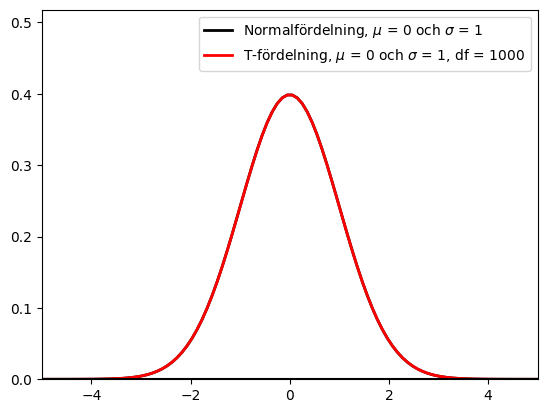

3.0618621784789726

In [25]:
# Compare t-dist and normal dist
 
# Plot normal dist
mu = 0
sigma = 1

limits = [mu - 5*sigma, mu + 5*sigma]

x = np.linspace(limits[0], limits[1], 100)
y_norm = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y_norm, 'k', lw=2)

# Plot t-dist
df = 1
y_t = stats.t.pdf(x, df, mu, sigma)
plt.plot(x, y_t, 'r', lw=2)

# Set x limits
plt.xlim(limits[0], limits[1])

# Draw x-axis
plt.axhline(0, color='k')

# Set y limits
plt.ylim(0, y_norm.max() * 1.3)

plt.legend([f'Normalfördelning, $\mu$ = {mu} och $\sigma$ = {sigma}', f'T-fördelning, $\mu$ = {mu} och $\sigma$ = {sigma}, df = {df}'], loc=1)
plt.show()